# Содержание:

    1) Метод word2vec с классификаторами:
            1) Ridge Classifier
            2) Perceptron
            3) Passive Agressive
            4) BeurnolliNB
            5) MultinomialNB
            6) KNeighbors
            7) RandomForest
            8) NearestCentroid
            9) SGDClassifier
            10) LinearSVC
    2) Визуализация


In [1]:
%matplotlib inline
import os
from lxml import etree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pymorphy2
import gensim
from sklearn.preprocessing import MinMaxScaler

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

## Загружаю данные:

In [2]:
f = open('./out.csv', 'r')
cl = {'статья':0,'интервью':1,'комментарий':2}
file_hash = {}
for line in f:
    attrs = line.split(';')
    path = attrs[0]
    class_name = attrs[8]
    if ' ' in class_name:
        class_name = class_name.split()[0]
    if '|' in class_name:
        class_name = class_name.split('|')[0]
    filename = os.path.basename(path)
    if class_name in cl:
        file_hash[filename] = cl[class_name]

In [3]:
morph = pymorphy2.MorphAnalyzer()
def normalize_and_add_pos(word):
    p = morph.parse(word)[0]
    return '{}_{}'.format(
        p.normal_form,
        p.tag.POS
    )

2017-04-24 09:02:37,034 INFO Loading dictionaries from /Users/Valeriya/anaconda/lib/python3.5/site-packages/pymorphy2_dicts/data
2017-04-24 09:02:37,150 INFO format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [4]:
def read_txt(path):
    for root, dirs, files in os.walk(path):
        for filename in files:
            open_name = os.path.join(root, filename)
            if filename in file_hash:
                class_text = file_hash[filename]
                tree = etree.parse(open_name)
                yield tree, class_text
                

In [5]:
sent = []
for tree, class_text in read_txt('/Users/Valeriya/Desktop/CoursePaper/corpus'):
    all_p = tree.xpath('//p')
    joined = '\n'.join([p.text for p in all_p if p.text is not None])
    sent.append((joined, class_text))

In [6]:
m = 'ruwikiruscorpora_0_300_20.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

2017-04-24 09:02:45,541 INFO loading projection weights from ruwikiruscorpora_0_300_20.bin.gz
2017-04-24 09:03:18,766 INFO loaded (392339, 300) matrix from ruwikiruscorpora_0_300_20.bin.gz


In [7]:
only_texts = [text[0] for text in sent]
classes = [text[1] for text in sent]


texts_norm = []
for text in sent:
    text_vectors = []
    words = text[0].split()
    for word in words:
        norm_word = normalize_and_add_pos(word)
        if norm_word in model:
            text_vectors.append(model[norm_word])
    mean_vector = sum(text_vectors) / len(text_vectors)
    texts_norm.append(mean_vector)

data = pd.DataFrame(texts_norm)
data['class'] = classes

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:300], data['class'], test_size=0.3)

In [8]:
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

## Классификаторы

In [9]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)
#     train_time = time() - t0
#     print("train time: %0.3fs" % train_time)

    t0 = time
    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_test)
    else:
        pred = clf.predict(X_test_norm)
        
#     test_time = time() - t0
#     print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    if "penalty" in vars(clf):
        return clf_descr+' '+str(clf.penalty), score
    else:
        return clf_descr, score

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(2)]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
accuracy:   0.500

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
accuracy:   0.507

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
accuracy:   0.445

kNN
__________________________________________________________________

/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.523

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.514

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


accuracy:   0.473

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.443

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
accuracy:   0.340

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
Near

## Визуализация

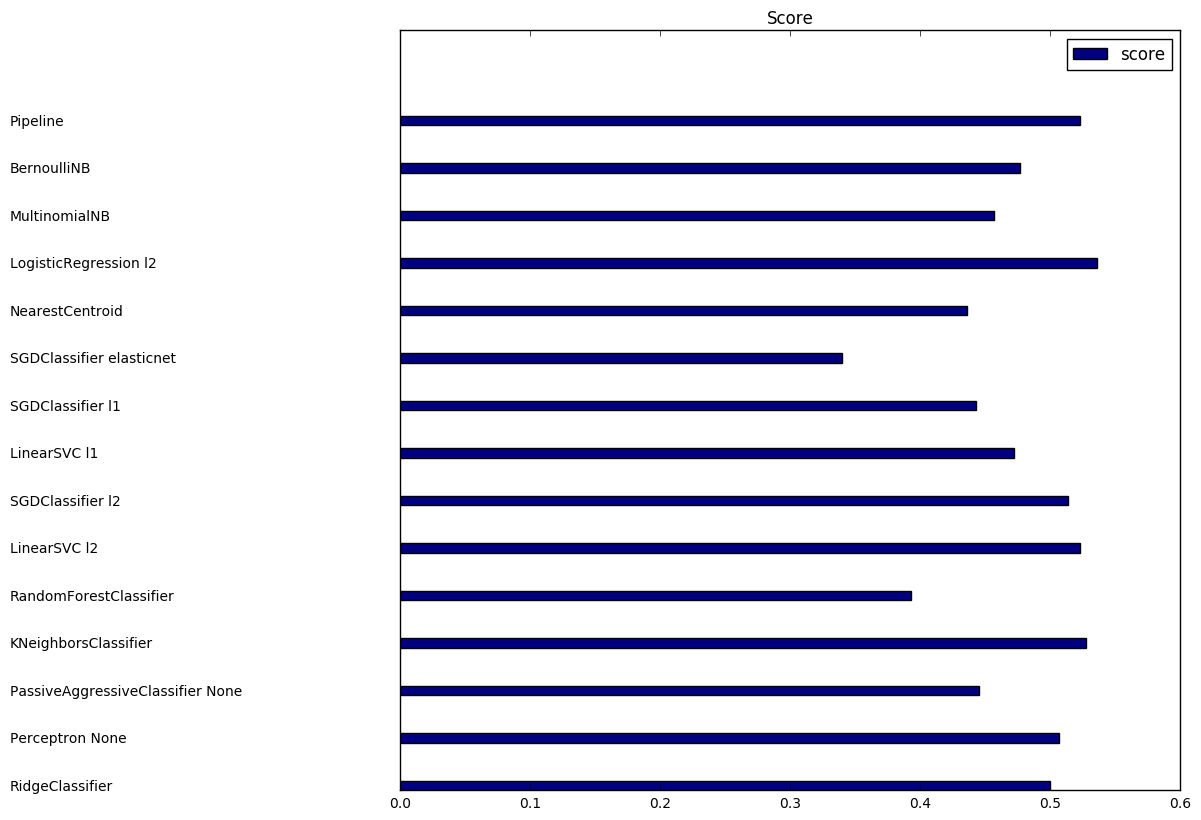

In [10]:
scores = results[1]
cls_names = results[0]

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, scores, .2, label="score", color='navy')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, results[0]):
    plt.text(-.3, i, c)
plt.show()

In [11]:
file = open('results.txt', 'a')
file.write('Word2vec Results')
file.write('\n')
file.write('\n')
for name, score in zip(results[0],results[1]):
    file.write(' '.join([name, str(score)]))
file.write('\n')

file.close()